# SMF of Jeremy's SDSS sample

In [1]:
import os 
import h5py
import numpy as np
# -- astrologs -- 
from astrologs.astrologs import Astrologs 
# -- galpopfm --
from galpopfm.catalogs import Catalog
# -- plotting --
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## read NSA catalog using `astrologs`

In [2]:
tinker = Catalog('tinker')

## sample cuts
our nsa subsample has the following sample cuts 
- redshift limit
- footprint cut to VAGC footprint
- absolute magnitude completeness limit ($M_r < -19.5$) 

(-30.0, 90.0)

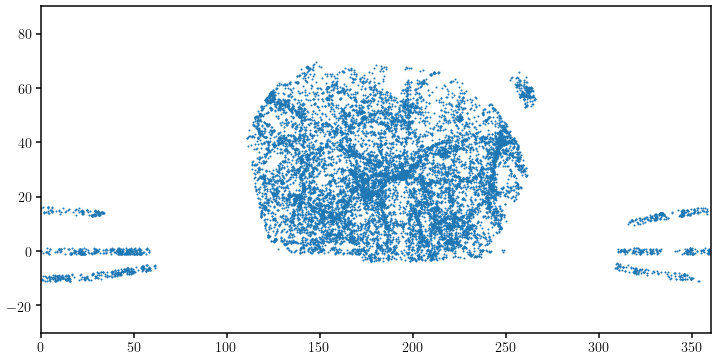

In [3]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(111)
sub.scatter(tinker.data['ra'], tinker.data['dec'], s=1, c='C0')
sub.set_xlim(0., 360.)
sub.set_ylim(-30, 90.)

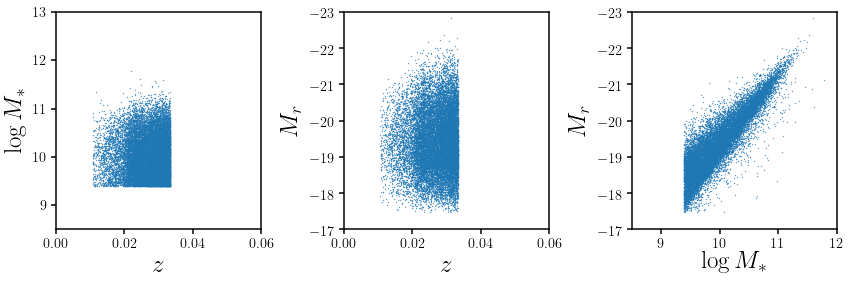

In [4]:
fig = plt.figure(figsize=(14,4))
sub = fig.add_subplot(131)
sub.scatter(tinker.data['redshift'], tinker.data['log.M_star'], s=0.1)
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_xlim(0., 0.06)
sub.set_ylabel(r'$\log M_*$', fontsize=25)
sub.set_ylim(8.5, 13.)

sub = fig.add_subplot(132)
sub.scatter(tinker.data['redshift'], tinker.data['M_r'], s=0.1)
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_xlim(0., 0.06)
sub.set_ylabel(r'$M_r$', fontsize=25)
sub.set_ylim(-17., -23)

sub = fig.add_subplot(133)
sub.scatter(tinker.data['log.M_star'], tinker.data['M_r'], s=0.1)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(8.5, 12.)
sub.set_ylabel(r'$M_r$', fontsize=25)
sub.set_ylim(-17., -23)
fig.subplots_adjust(wspace=0.4)

# calculate SMF

In [5]:
logms_bin = np.linspace(8., 13., 26)
dlogms = logms_bin[1:] - logms_bin[:-1]

In [6]:
Ngal_tinker, _ = np.histogram(tinker.data['log.M_star'], bins=logms_bin) 
phi_tinker = Ngal_tinker.astype(float) / tinker.cosmic_volume / dlogms

(5e-05, 0.1)

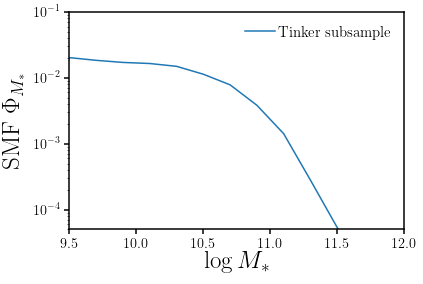

In [7]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(0.5*(logms_bin[1:] + logms_bin[:-1]), phi_tinker, label='Tinker subsample')

sub.legend(loc='upper right', frameon=False, handletextpad=0.2, fontsize=15)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(9.5, 12.)
sub.set_ylabel(r'SMF $\Phi_{M_*}$', fontsize=25)
sub.set_yscale("log")
sub.set_ylim(5e-5, 1e-1)

Lets get some jackknife uncertainties on the SMF

In [8]:
jk_fields = [] 
jk_fields.append(tinker.data['ra'] < 100)

ra_bins = np.linspace(110, 270, 4)
dec_bins = np.linspace(-11., 70., 4)
for i in range(len(ra_bins)-1): 
    for j in range(len(dec_bins)-1): 
        infield = ((tinker.data['ra'] > ra_bins[i]) & (tinker.data['ra'] < ra_bins[i+1]) & 
                   (tinker.data['dec'] > dec_bins[j]) & (tinker.data['dec'] < dec_bins[j+1]))
        jk_fields.append(infield)
jk_fields.append(tinker.data['ra'] > 300)

for i, field in enumerate(jk_fields): 
    print('field %i: %i' % (i, np.sum(field)))

field 0: 735
field 1: 1287
field 2: 2171
field 3: 1104
field 4: 1917
field 5: 3904
field 6: 1229
field 7: 1125
field 8: 2364
field 9: 602
field 10: 532


In [9]:
# estimate the fraction of the footprint using random
from astropy.io import fits
random = fits.open(os.path.join(os.environ['GALPOPFM_DIR'], 'obs', 'lss_random-0.dr72.fits'))[1].data
n_random = len(random['RA'])

In [10]:
jk_f_footprint = [] 
jk_f_footprint.append(float(np.sum(random['RA'] < 100))/float(n_random))

ra_bins = np.linspace(110, 270, 4)
dec_bins = np.linspace(-11., 70., 4)
for i in range(len(ra_bins)-1): 
    for j in range(len(dec_bins)-1): 
        infield = ((random['RA'] > ra_bins[i]) & (random['RA'] < ra_bins[i+1]) & 
                   (random['DEC'] > dec_bins[j]) & (random['DEC'] < dec_bins[j+1]))
        jk_f_footprint.append(float(np.sum(infield))/float(n_random))
jk_f_footprint.append(float(np.sum(random['ra'] > 300))/float(n_random))

jk_f_footprint = np.array(jk_f_footprint)/np.sum(jk_f_footprint)

(-30.0, 90.0)

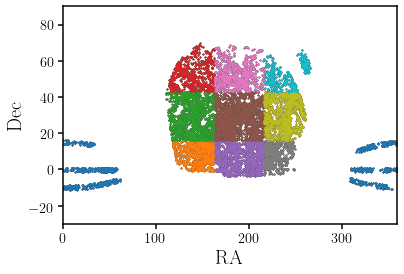

In [11]:
plt.scatter(tinker.data['ra'], tinker.data['dec'], c='k', s=1)
for field in jk_fields: 
    plt.scatter(tinker.data['ra'][field], tinker.data['dec'][field], s=1)
plt.xlabel('RA', fontsize=20)
plt.xlim(0., 360)
plt.ylabel('Dec', fontsize=20)
plt.ylim(-30, 90)

In [12]:
jk_phis = [] 
for field, f_footprint in zip(jk_fields, jk_f_footprint): 
    _Ngal, _ = np.histogram(tinker.data['log.M_star'][~field], bins=logms_bin) 
    _phi = _Ngal.astype(float) / ((1.-f_footprint) * tinker.cosmic_volume) / dlogms
    jk_phis.append(_phi)

n_jk = len(jk_phis)
jk_avg_phi = np.sum(np.array(jk_phis), axis=0)/float(n_jk)
phi_err_jk = np.sqrt(float(n_jk-1)/float(n_jk)*np.sum(np.array([(_phi - jk_avg_phi)**2 for _phi in jk_phis]), axis=0))

(5e-05, 0.1)

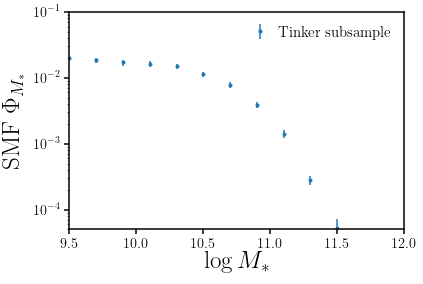

In [13]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.errorbar(0.5*(logms_bin[1:] + logms_bin[:-1]), phi_tinker, yerr=phi_err_jk, 
             fmt='.C0', label='Tinker subsample')
sub.legend(loc='upper right',handletextpad=0.2, fontsize=15)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(9.5, 12.)
sub.set_ylabel(r'SMF $\Phi_{M_*}$', fontsize=25)
sub.set_yscale("log")
sub.set_ylim(5e-5, 1e-1)

# Comparison to simulations
Lets compare to SIMBA and TNG

In [14]:
simba = Catalog('simba')
tng = Catalog('tng')

In [15]:
Ngal_simba, _ = np.histogram(simba.data['logmstar'], bins=logms_bin)
Ngal_tng, _ = np.histogram(tng.data['logmstar'], bins=logms_bin)

In [16]:
phi_simba = Ngal_simba.astype(float) / simba.cosmic_volume / dlogms
phi_tng = Ngal_tng.astype(float) / tng.cosmic_volume / dlogms

(1e-06, 0.1)

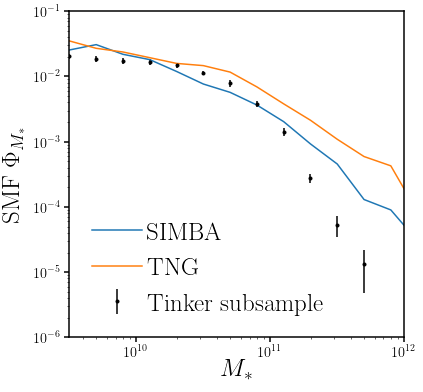

In [17]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.errorbar(10**(0.5*(logms_bin[1:] + logms_bin[:-1])), phi_tinker, yerr=phi_err_jk, 
             fmt='.k', label='Tinker subsample')

sub.plot(10**(0.5*(logms_bin[1:] + logms_bin[:-1])), phi_simba, label='SIMBA')
sub.plot(10**(0.5*(logms_bin[1:] + logms_bin[:-1])), phi_tng, label='TNG')

sub.legend(loc='lower left',handletextpad=0.2, fontsize=25)
sub.set_xlabel(r'$M_*$', fontsize=25)
sub.set_xlim(10**9.5, 10**12.)
sub.set_xscale('log')
sub.set_ylabel(r'SMF $\Phi_{M_*}$', fontsize=25)
sub.set_yscale("log")
sub.set_ylim(1e-6, 1e-1)


In [18]:
f_phi = os.path.join(os.environ['GALPOPFM_DIR'], 'obs', 'tinker.smf.dat') 
np.savetxt(f_phi, np.array([logms_bin[:-1], logms_bin[1:], phi_tinker, phi_err_jk]).T)